In [1]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

# 5.2 prepare particles

In [2]:
class Mcl:
    def __init__(self, init_pose, num):
        self.particles = [Particle(init_pose) for i in range(num)]
        
    def draw(self, ax, elems):
        start_xs = [p.pose[0] for p in self.particles]         
        start_ys = [p.pose[1] for p in self.particles] 
        end_xs = [math.cos(p.pose[2]) for p in self.particles]         
        end_ys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(start_xs, start_ys, end_xs, end_ys, color="blue", alpha=0.5))

In [3]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose

In [4]:
class EstimationAgent(Agent):
    def __init__(self, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)          

### create world and add landmarks

In [5]:
world = World(30, 0.1)
map = Map()
for lndmk in [(-4,2),(2,-3),(3,3)]:
    map.append_landmark(Landmark(*lndmk))
world.append(map)

### create robot

In [6]:
initial_pose = np.array([2,2,math.pi / 6])
estimator = Mcl(initial_pose, 100)
circling = EstimationAgent(0.2, 10/180*math.pi, estimator)
robo = Robot(initial_pose, sensor=Camera(map), agent=circling)
world.append(robo)

<IPython.core.display.Javascript object>


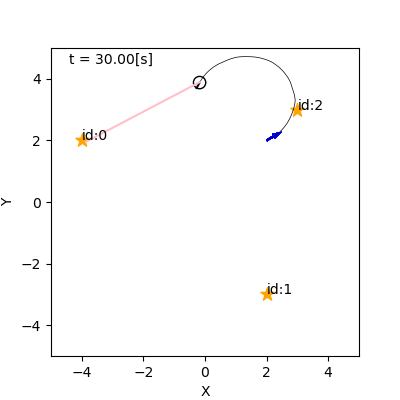

In [7]:
world.draw()

# 5.3 update poses of particles

In [17]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu = self.nu
        self.prev_omega = self.omega
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)     

In [18]:
class Mcl:
    def __init__(self, init_pose, num, motion_noise_stds):
        self.particles = [Particle(init_pose) for i in range(num)]
        s = motion_noise_stds
        cov = np.diag([s["nn"]**2, s["no"]**2, s["on"]**2, s["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=cov)
        
    def motion_update(self, nu, omega, dt):
        for p in self.particles: p.motion_update(nu, omega, dt, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems):
        start_xs = [p.pose[0] for p in self.particles]         
        start_ys = [p.pose[1] for p in self.particles] 
        end_xs = [math.cos(p.pose[2]) for p in self.particles]         
        end_ys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(start_xs, start_ys, end_xs, end_ys, color="blue", alpha=0.5))

In [19]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def motion_update(self, nu, omega, dt, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        randomised_nu = nu + ns[0]*math.sqrt(abs(nu)/dt) + ns[1]*math.sqrt(abs(omega)/dt)
        randomised_omega = omega + ns[2]*math.sqrt(abs(nu)/dt) + ns[3]*math.sqrt(abs(omega)/dt)
        self.pose = IdealRobot.state_transition(randomised_nu, randomised_omega, dt, self.pose)

In [23]:
initial_pose = np.array([0,0,0]).T
estimator = Mcl(init_pose=initial_pose, num=100, motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
agent = EstimationAgent(0.1, 0.2, 10/180*math.pi, estimator)
estimator.motion_update(0.2, 10/180*math.pi, 0.1)
for p in estimator.particles:
    #print(p.pose)
    pass

In [24]:
def trial(motion_noise_stds):
    time_interval = 0.1
    world = World(30, time_interval)
    
    initial_pose = np.array([0,0,0])
    estimator = Mcl(initial_pose, 100, motion_noise_stds)
    circling = EstimationAgent(time_interval, 0.2, 10/180*math.pi, estimator)
    robo = Robot(initial_pose, sensor=Camera(map), agent=circling, color="red")
    world.append(robo)
    world.draw()

<IPython.core.display.Javascript object>


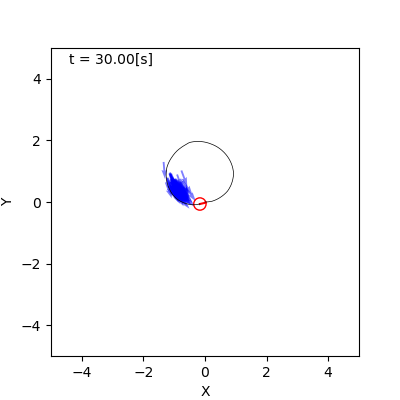

In [25]:
trial({"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})